## import libraries and data

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [2]:
train = pd.read_csv('written_name_train_v2.csv')
val = pd.read_csv('written_name_validation_v2.csv')



In [3]:
train.head(2)

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON


### visualize some of the data 

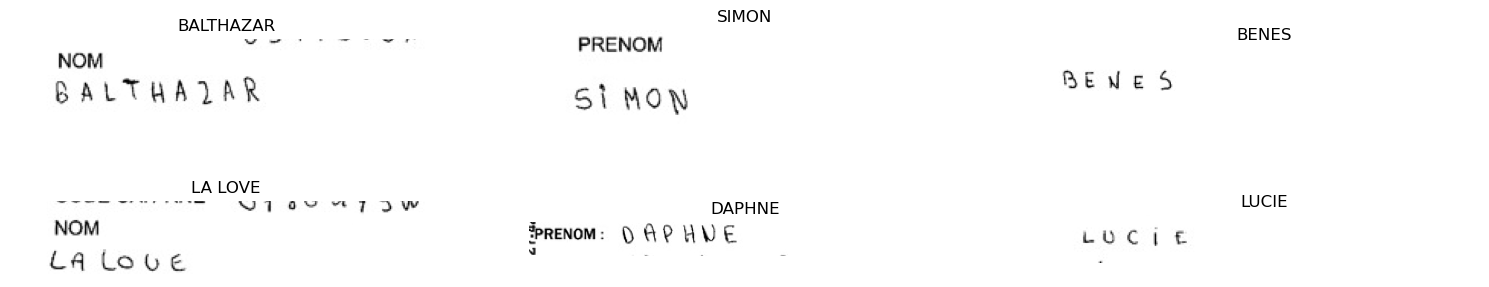

In [4]:
plt.figure(figsize=(15, 10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

### check for nulls 

In [5]:
train['IDENTITY'].isnull().sum(),val['IDENTITY'].isnull().sum()


(565, 78)

In [6]:
train.dropna(axis=0, inplace=True)
val.dropna(axis=0, inplace=True)

## we also have unreadable images 

In [7]:
unreadable = train[train['IDENTITY'] =='UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

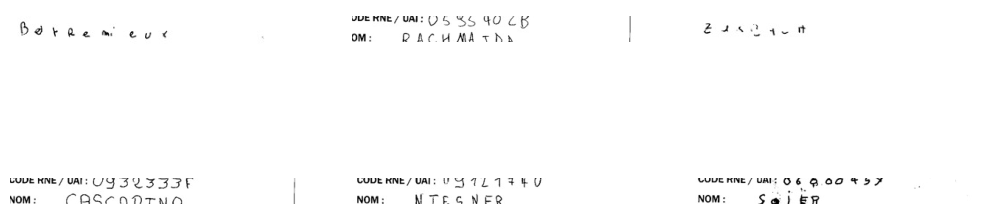

In [8]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    img_dir = 'train_v2/train/' + unreadable.loc[i,'FILENAME']
    image = cv2.imread(img_dir,cv2.IMREAD_GRAYSCALE)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## remove unreadables 

In [9]:
train = train.loc[train['IDENTITY']!='UNREADABLE']
val = val.loc[val['IDENTITY']!='UNREADABLE']

## make them all upercase 

In [10]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
val['IDENTITY'] = val['IDENTITY'].str.upper()

In [11]:
train.reset_index(inplace = True, drop=True) 
val.reset_index(inplace = True, drop=True)

In [12]:
train.head(2)

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON


## preprocces of images  

In [13]:
def pre_img(image):
    (h,w) = image.shape
    
    
    final_image = np.ones([64,256])*255 # we take an 'empty ' image 
    
    if w > 256:
        image = image[:,:256] # we take only 256 
    
    if h > 64: 
        image = image[:64,:] # we take only 64 
        
    final_image[:h,:w] = image  # we fill the new image with the (256,64) of the original image 
    
    return cv2.rotate(final_image,cv2.ROTATE_90_CLOCKWISE)
    

## get the training and the validation images 

In [14]:
train_size = 30000
val_size = 3000


In [15]:
train_x = []

for i in range(train_size):
    img_dir = 'train_v2/train/' + train.loc[i,'FILENAME']
    image = cv2.imread(img_dir,cv2.IMREAD_GRAYSCALE)
    image = pre_img(image)
    image = image/255.
    train_x.append(image)

In [16]:
val_x = []

for i in range(val_size):
    img_dir = 'validation_v2/validation/' + val.loc[i,'FILENAME']
    image = cv2.imread(img_dir,cv2.IMREAD_GRAYSCALE)
    image = pre_img(image)
    image = image/255.
    val_x.append(image)

## reshape them 

In [17]:
train_x = np.array(train_x).reshape(-1,256,64,1)
val_x = np.array(val_x).reshape(-1,256,64,1)

## prepare the labels for CTC loss

In [18]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 
num_of_characters = len(alphabets) + 1 
num_of_timestamps = 64 


In [19]:
def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1: 
            break
        else:
            ret+=alphabets[ch]
    return ret

In [20]:
name = 'NIKOS'
print(name,'\n',label_to_num(name))

NIKOS 
 [13  8 10 14 18]


## PREPARE the labels 

In [21]:
train_y = np.ones([train_size,max_str_len]) * 1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

In [22]:
for i in range(train_size):
    train_label_len[i] = len(train.loc[i,'IDENTITY'])
    train_y[i,0:len(train.loc[i,'IDENTITY'])] = label_to_num(train.loc[i,'IDENTITY'])

In [23]:
train_y[0]

array([ 1.,  0., 11., 19.,  7.,  0., 25.,  0., 17.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [24]:
train_label_len[0]

array([9.])

## for valid also 

In [25]:
valid_y = np.ones([val_size, max_str_len]) * -1
valid_label_len = np.zeros([val_size, 1])
valid_input_len = np.ones([val_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([val_size])

for i in range(val_size):
    valid_label_len[i] = len(val.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(val.loc[i, 'IDENTITY'])]= label_to_num(val.loc[i, 'IDENTITY'])  

## MODEL BUILDING 

In [26]:
input_data = Input(shape=(256, 64, 1), name='input')

x = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), name='max1')(x)

x = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), name='max2')(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(1, 2), name='max3')(x)
x = Dropout(0.3)(x)

# CNN to RNN
x = Reshape(target_shape=((64, 1024)), name='reshape')(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(x)

## RNN
x = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(x)
x = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(x)

## OUTPUT
x = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(x)
y_pred = Activation('softmax', name='softmax')(x)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 256, 64, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

## create the ctc loss 

In [27]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    y_pred = y_pred[:, 2:, :] # dont use the first two because the are not usefull most of the times 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [28]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

## create callbacks

In [30]:
from tensorflow.keras.callbacks import EarlyStopping ,ModelCheckpoint



early_stop  = EarlyStopping( monitor='val_loss',
    min_delta=0,
    patience=6,
    start_from_epoch=10
)



checkpoint = ModelCheckpoint('weights.h5',
    monitor= 'val_loss',
    verbose = 0,
    save_best_only= True,
    save_weights_only = True,)

# train

In [31]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([val_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=40, batch_size=128,callbacks=[early_stop,checkpoint])

Epoch 1/40



235/235 [==============================] - 906s 4s/step - loss: 21.4062 - val_loss: 20.4738
Epoch 2/40
235/235 [==============================] - 916s 4s/step - loss: 17.6785 - val_loss: 54.7225
Epoch 3/40
235/235 [==============================] - 894s 4s/step - loss: 7.4189 - val_loss: 34.3514
Epoch 4/40
235/235 [==============================] - 900s 4s/step - loss: 3.6863 - val_loss: 4.2042
Epoch 5/40
235/235 [==============================] - 892s 4s/step - loss: 2.8185 - val_loss: 13.3563
Epoch 6/40
235/235 [==============================] - 889s 4s/step - loss: 2.3689 - val_loss: 14.3858
Epoch 7/40
235/235 [==============================] - 889s 4s/step - loss: 2.1161 - val_loss: 7.9946
Epoch 8/40
235/235 [==============================] - 917s 4s/step - loss: 1.9464 - val_loss: 7.8515
Epoch 9/40
235/235 [==============================] - 925s 4s/step - loss: 1.7978 - val_loss: 7.6871
Epoch 10/40
235/235 [==============================] - 934s 4s/step - loss: 1.6856 - val_loss: 

# load best weights

In [33]:
model.load_weights('weights.h5')

## see the history

In [34]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

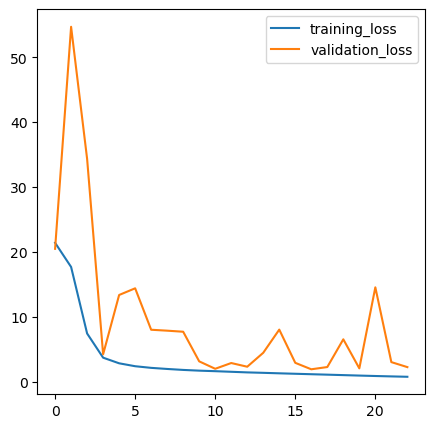

In [37]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()
plt.show()

## make preidctions 

In [39]:
preds = model.predict(val_x)

94/94 [==============================] - 44s 401ms/step


In [41]:
# decoded preds

actual_preds = K.get_value(K.ctc_decode(preds,input_length=np.ones(preds.shape[0])*preds.shape[1],greedy=True)[0][0])

In [42]:
predictions = []
for i in range(val_size):
    predictions.append(num_to_label(actual_preds[i]))

## compare 

In [44]:
val_true = val.loc[0:val_size,'IDENTITY']


In [47]:
for i in range(len(val_true[:10])):
    print(val_true[i],predictions[i])

BILEL BILEL
LAUMIONIER LAUMONIER
LEA LEA
JEAN-ROCH JEAN-ROCH
RUPP RUPP
PICHON PICHON
DANIEL GBDANIEL
JEREMY GJEREMY
JEAN-MICHEL GJEAN-MICHEL
JULIEN JULIEN


In [57]:
correct_char = 0
total_corect = 0
total_chars = 0

for i in range(val_size):
    pred = predictions[i]
    act = val_true[i]
    total_chars += len(act)
    
    
    
    maxx = [len(pred) if len(pred)<len(act) else len(act)]
    
    
    for i in range(maxx[0]):
        if act[i] == pred[i]:
            correct_char += 1
            
    if pred == act:
        total_corect +=1
    

In [63]:
print('corect characters predicted : %.2f%%' %(correct_char*100/total_chars) )
print('corect words predicted : %.2f%%' %(total_corect*100/val_size))


corect characters predicted : 70.15%
corect words predicted : 58.03%


## read the test set and see the results 

In [95]:
test = pd.read_csv('written_name_test_v2.csv')

In [96]:
# get the images

test_images_path = []
path = 'test_v2/test/'

for i in range(12):
    image_name = test.loc[i,'FILENAME']
    total_path = path+image_name
    test_images_path.append(total_path)
    
    

In [97]:
procecced_test = []
for path in test_images_path:
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = pre_img(img)
    img = img/255.
    procecced_test.append(img)
    
    
    

In [98]:
test_preds = []

for image in procecced_test:
    t_pred = model.predict(image.reshape(1,256,64,1))
    t_decoded = K.get_value(K.ctc_decode(t_pred, input_length=np.ones(t_pred.shape[0])*t_pred.shape[1], 
                                       greedy=True)[0][0])
    value = num_to_label(t_decoded[0])
    test_preds.append(value)

1/1 [==============================] - 0s 69ms/step


In [99]:
actuals_t = test.loc[:12,'IDENTITY'].values


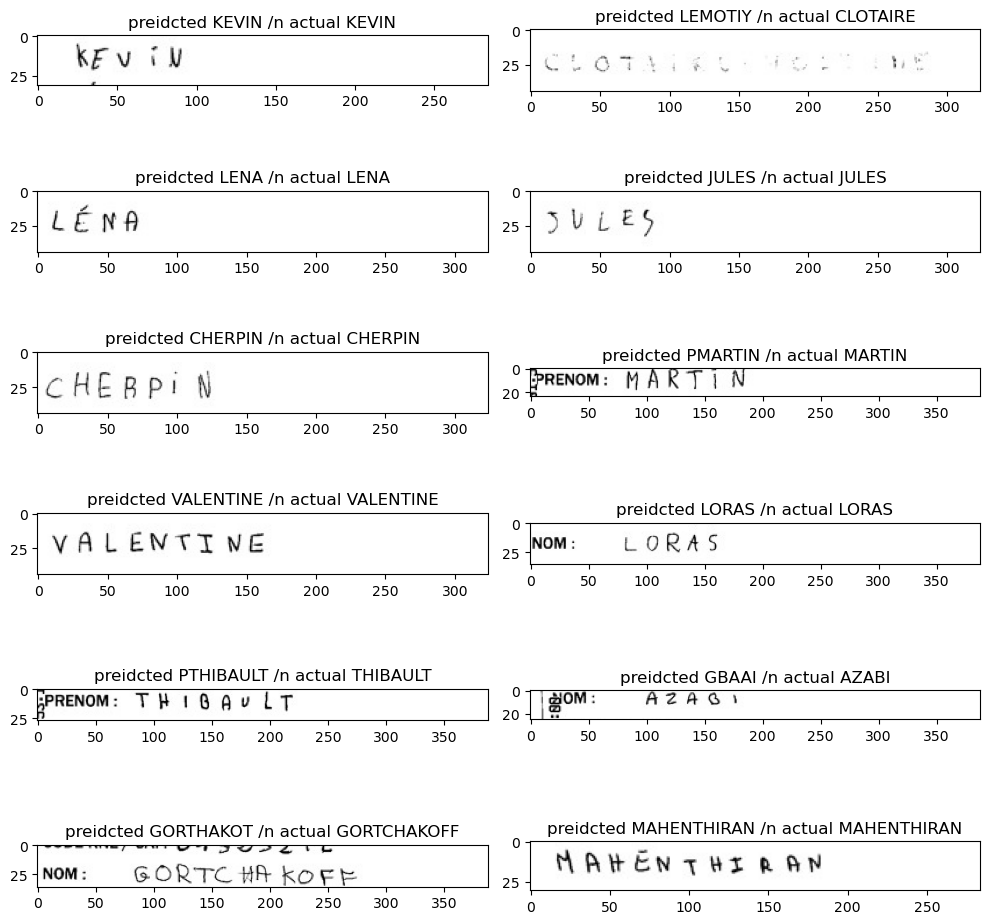

In [102]:
plt.figure(figsize =(10,10))
for i in range(12):
    plt.subplot(6,2,i+1)
    img = cv2.imread(test_images_path[i])
    plt.imshow(img)
    plt.title(f'preidcted {test_preds[i]}  actual {actuals_t[i]}')
plt.tight_layout()
plt.show()

## lets see the metrics for our test_Set

In [105]:
correct_char = 0
total_corect = 0
total_chars = 0
test_s = len(test_preds)

for i in range(test_s):
    pred = test_preds[i]
    act = actuals_t[i]
    total_chars += len(act)
    
    
    
    maxx = [len(pred) if len(pred)<len(act) else len(act)]
    
    
    for i in range(maxx[0]):
        if act[i] == pred[i]:
            correct_char += 1
            
    if pred == act:
        total_corect +=1
print('corect characters predicted : %.2f%%' %(correct_char*100/total_chars) )
print('corect words predicted : %.2f%%' %(total_corect*100/test_s))


corect characters predicted : 63.10%
corect words predicted : 58.33%


## our model does prety well , lets save it 

In [108]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
